In [2]:
import util as u
import pandas as pd
import pyBigWig
import numpy as np
import seaborn as sns
import re
from liftover import get_lifter
from bisect import bisect_left
import matplotlib.pyplot as plt

data='/labs/mpsnyder/moqri/data/index/'

hg19tohg38='http://hgdownload.soe.ucsc.edu/goldenPath/hg19/liftOver/hg19ToHg38.over.chain.gz'


def get_bar(df,cells):
    sns.set(rc={'figure.figsize':(25,2.5)})
    fig, axes = plt.subplots(nrows=1, ncols=5)
    df[cells].mean().plot(kind='bar',ax=axes[0])
    dl=df[df.h9<.2]
    for cell in cells:
        dl[cell+'_d']=dl[cell]-dl.h9
    print(dl.shape)
    dl[[cell+'_d' for cell in cells]].mean().plot(kind='bar',ax=axes[1])
    dle=dl[dl.ezh.notna()].drop(['g','tss','d'],axis=1)
    print(dle.shape)
    dle[[cell+'_d' for cell in cells]].mean().plot(kind='bar',ax=axes[2])
    dh=df[df.h9>.6]
    print(dh.shape)
    for cell in cells:
        dh[cell+'_d']=dh.h9-dh[cell]
    dh[[cell+'_d' for cell in cells]].mean().plot(kind='bar',ax=axes[3])
    dho=dh[dh.flank.str[0].isin(['A','T'])&dh.flank.str[3].isin(['A','T'])].drop(['g','tss','d'],axis=1)
    print(dho.shape)
    dho[[cell+'_d' for cell in cells]].mean().plot(kind='bar',ax=axes[4])
    plt.show()
    #df.d.hist(bins=100)

def get_fig(df,cell,label,pal):
    sns.set(rc={'figure.figsize':(3.5,2.5)})
    pl=df[cell+['dq']].groupby('dq').mean()[cell]
    pl.columns=label
    pl.index=list(range(-2500,2501,500))
    plt.figure()
    ax=sns.lineplot(data=pl,dashes=False,hue_order=label[::-1],
                    palette = sns.color_palette(pal))
    plt.figure()
    dl=df[df.h9<.2]
    pl=dl.groupby('dq').mean()[cell]
    pl.columns=label
    pl.index=list(range(-2500,2501,500))
    ax=sns.lineplot(data=pl,dashes=False,hue_order=label[::-1],
                    palette = sns.color_palette(pal),legend=False)
    plt.figure()
    dle=dl[dl.ezh.notna()].drop(['g','tss','d'],axis=1)
    print(dle.shape)
    pl=dle.groupby('dq').mean()[cell]
    pl.columns=label
    pl.index=list(range(-2500,2501,500))
    ax=sns.lineplot(data=pl,dashes=False,hue_order=label[::-1],
                    palette = sns.color_palette(pal),legend=False)
    plt.figure()
    dh=df[df.h9>.6]
    pl=dh.groupby('dq').mean()[cell]
    pl.columns=label
    pl.index=list(range(-2500,2501,500))
    ax=sns.lineplot(data=pl,dashes=False,hue_order=label[::-1],
                    palette = sns.color_palette(pal),legend=False)
    plt.figure()
    dho=dh[dh.flank.str[0].isin(['A','T'])&dh.flank.str[3].isin(['A','T'])].drop(['g','tss','d'],axis=1)
    pl=dho.groupby('dq').mean()[cell]
    pl.columns=label
    pl.index=list(range(-2500,2501,500))
    ax=sns.lineplot(data=pl,dashes=False,hue_order=label[::-1],
                    palette = sns.color_palette(pal),legend=False)        

In [3]:
tss=pd.read_csv('files/tss38.csv',index_col=0)
print(tss.shape)
ezh=tss[tss.v>1]
ezh.shape

(31335, 8)


(929, 8)

In [4]:
an=pd.read_csv(data+'wg/ann.csv',index_col=0)
an.columns=['h9']+list(an.columns)[1:]
an.shape

(3153046, 11)

In [9]:
cells=['nb','md','ct']#,'sy','so']
df=an
for cell in cells:
    print(cell,end=',')
    dt=pd.read_csv(data+'wg/'+cell+'.csv',index_col=0)
    dt.columns=[cell]
    df=df.merge(dt,how='left',left_index=True,right_index=True)
len(df)/(10**6)    
df=df[df[cells].notna().all(1)]
df['dq']=pd.qcut(df.d,11)
df.shape

nb,md,ct,

(3153046, 14)

(1543010, 17)
(178653, 14)
(1433233, 14)
(166287, 14)


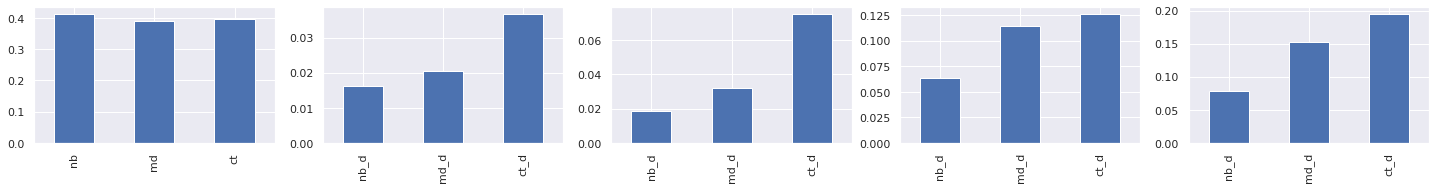

In [44]:
#fig, ax = plt.subplots(nrows=1, ncols=5)
bar(df,cells)

/oak/stanford/scg/lab_mpsnyder/moqri/aging/index/util.py:150: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  dle=dl[dl.ezh.notna()].drop(['g','tss','d'],1)


(178653, 11)


/oak/stanford/scg/lab_mpsnyder/moqri/aging/index/util.py:165: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  dho=dh[dh.flank.str[0].isin(['A','T'])&dh.flank.str[3].isin(['A','T'])].drop(['g','tss','d'],1)


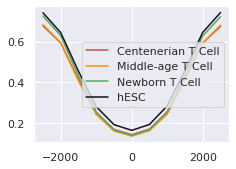

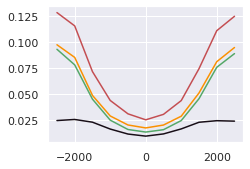

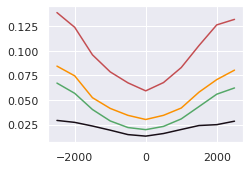

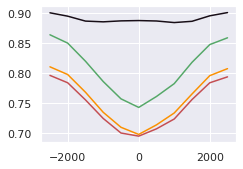

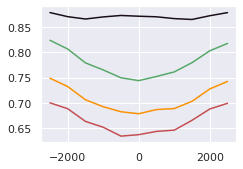

In [48]:
sample=    {'cells':['h9','nb','md','ct'],
     'labels':['hESC','Newborn T Cell','Middle-age T Cell','Centenerian T Cell'],
     'pal':["#c44e52","#FB9101","#55a868","#180e17"]
    }
u.fig(df,sample['cells'],sample['labels'],sample['pal'])    

In [49]:
sample={'cells':['h9','sy','so'],
      'labels':['hESC','Young Epidermis','Old Epidermis'],
     'pal':["#c44e52","#55a868","#180e17"]
    }
#fig(df,sample['cells'],sample['labels'],sample['pal'])    

In [6]:
#cancer
cells=['n1','c1','c2']
ca=pd.read_table(data+'/cancer/bc_38.bed',header=None)
print(len(ca)/(10**6))
ca.columns=['chr','b1','b2']+cells
ca.index=ca['chr'].str[3:]+'_'+ca['b1'].astype(str)
ca=ca[ca.index.isin(an.index)]
ca=ca.drop_duplicates()
ca=ca[~ca.index.duplicated()]

5.789698


In [8]:
df=an.merge(ca[cells],left_index=True,right_index=True,how='left')
df.shape

(3153046, 15)

In [9]:
df=df[df[cells].notna().all(1)]
df.shape

(1734039, 15)

In [10]:
df[['h9']+cells].mean()

h9    0.239509
n1    0.233720
n2    0.229665
c1    0.227097
c2    0.243277
dtype: float64

(1250246, 18)
(149231, 15)
(409668, 15)
(26437, 15)


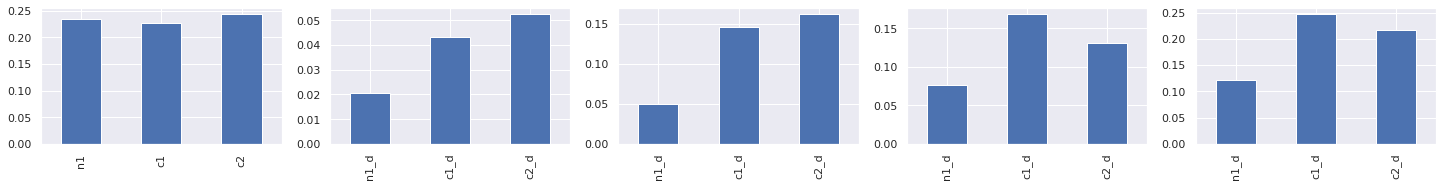

In [15]:
cells=['n1','c1','c2']
get_bar(df,cells)

In [16]:
sns.set(rc={'figure.figsize':(3.5,2.5)})

(149231, 12)


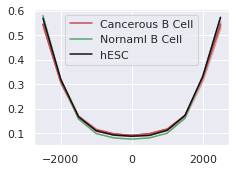

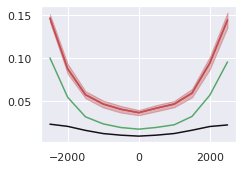

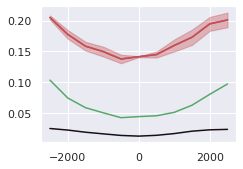

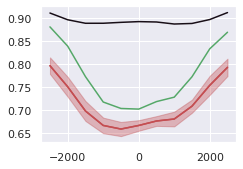

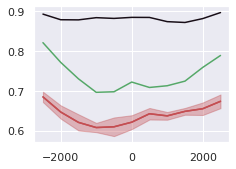

In [17]:
sample={'cells':['h9']+cells,
      'labels':['hESC','Nornaml B Cell','Cancerous B Cell','Cancerous B Cell'],
     'pal':["#c44e52","#c44e52","#55a868",'#180e17']
    }
df['dq']=pd.qcut(df.d,11)
get_fig(df,sample['cells'],sample['labels'],sample['pal'])    

In [7]:
df

NameError: name 'df' is not defined

In [71]:


wb450='https://ftp.ncbi.nlm.nih.gov/geo/series/GSE40nnn/GSE40279/matrix/GSE40279_series_matrix.txt.gz'
!wget -q -nc {wb450} -O {data}450\wb450.gz
blood=pd.read_csv(data+'450/wb450.gz',sep='\t',index_col=0,skiprows=69, nrows=10**6)
print(blood.shape)
b_ages=pd.read_csv(data+'450/wb450.gz',sep='\t',skiprows=33,nrows=0,index_col=0).columns.values
b_ages=[float(age.strip('age: ').split('y')[0]) for age in b_ages]



<ipython-input-71-7e6e862c9e3b>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  man=man[~man.CpG_chrm.isna()][man.CpG_chrm!='chrX'][man.CpG_chrm!='chrY'][man.CpG_chrm!='chrM']


(473035, 656)
(485577, 85)


<ipython-input-72-5fbc4d980710>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  b=blood.T.drop('!series_matrix_table_end',1)


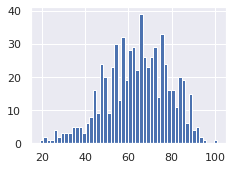

In [72]:
b=blood.T.drop('!series_matrix_table_end',1)
b['age']=b_ages
b.age.hist(bins=50)
b['age']=pd.cut(b.age,[20,30,40,50,60,70,80,90,100])
b=b.groupby('age').mean()

In [74]:
arr(dl)

NameError: name 'dl' is not defined

(11707, 57)
(11699, 2)


<ipython-input-27-0da555e7adb0>:18: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  scg=pd.concat([sc1,sc2],1)
<ipython-input-27-0da555e7adb0>:21: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  pls=pd.concat([scg,pl],1)


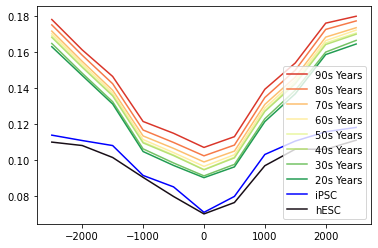

In [84]:
arr(dle)

(61253, 57)
(61161, 2)


<ipython-input-27-0da555e7adb0>:18: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  scg=pd.concat([sc1,sc2],1)
<ipython-input-27-0da555e7adb0>:21: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  pls=pd.concat([scg,pl],1)


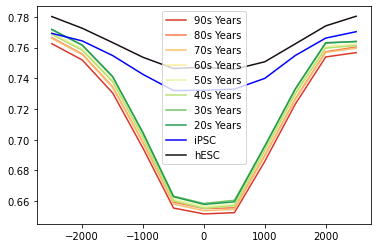

In [29]:
arr(dh)

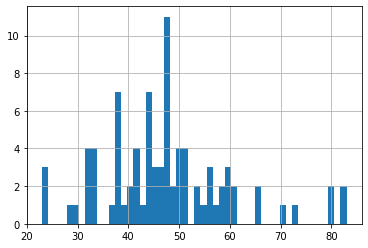

(9106, 2)


In [62]:
pl.columns=pl.columns.rename('Liver Age')
pl.columns=['20-30 Years','30-40 Years','40-50 Years','50+ Years']
scl=sc.loc[ll.probeID]
scl['dq']=ll.dq.values
sc1=scl[list(meta[meta.index.str.contains('ES__')]['!Sample_geo_accession'].values)+['dq']].groupby('dq').mean().mean(1)
sc2=scl[list(meta[meta.index.str.contains('iPS__')]['!Sample_geo_accession'].values)+['dq']].groupby('dq').mean().mean(1)
scg=pd.concat([sc1,sc2],1)
scg.index=pl.index
scg.columns=['hESC','iPSC']
pls=pd.concat([scg,pl],1)

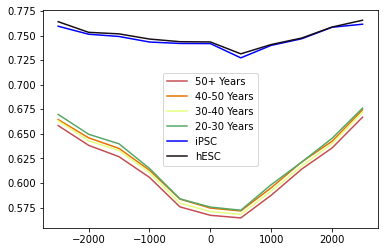

In [70]:
ax=sns.lineplot(data=pls,dashes=False,hue_order=['50+ Years','40-50 Years','30-40 Years','20-30 Years','iPSC','hESC'],
                palette = sns.color_palette(["#c44e52","#E57300","#E4FF7F","#55a868","#0000FF","#180e17"]))